# Basics of Quantization

This tutorial demonstrates how to use the QLIP library to quantize large language models, specifically focusing on Llama 3.1 8B Instruct. We'll cover the fundamentals of quantization, implement different quantization algorithms, and evaluate their impact on model performance.

## Table of Contents
1. [Introduction to Quantization](#1-introduction-to-quantization)
2. [Model and Data Preparation](#2-model-and-data-preparation)
3. [Post-Training Quantization](#3-post-training-quantization)
3.1 [MMLU Evaluation](#3.1-mmlu-evaluation)
4. [Activation Distribution Analysis](#4-activation-distribution-analysis)
5. [SmoothQuant Algorithm](#5-smoothquant-algorithm)
6. [Dynamic quantization](#6-dynamic-quantization)

## 1. Introduction to Quantization

### What is Quantization?

Quantization is one of the most effective techniques for making deep neural networks more efficient and deployable in resource-constrained environments. At its core, quantization involves reducing the numerical precision of a model's weights and activations from their original high-precision floating-point representations to lower-precision formats. This process can dramatically reduce model size, memory bandwidth requirements, and computational complexity while maintaining acceptable accuracy levels.

### Symmetric vs. Asymmetric Quantization: 
Symmetric quantization assumes the data distribution is centered around zero, using the same scale for positive and negative values. Asymmetric quantization accommodates arbitrary data ranges by introducing both scale and zero-point parameters, offering greater flexibility for activation functions with non-zero means.

### Static vs. Dynamic Quantization: 
Static quantization determines quantization parameters during a calibration phase using representative data, then fixes these parameters during inference. Dynamic quantization computes quantization parameters on-the-fly during inference, adapting to the actual data distribution but incurring additional computational overhead.

### Challenges:
- **Accuracy Degradation**: Loss of precision can hurt model performance
- **Outlier Sensitivity**: Extreme values can skew quantization scales
- **Layer Sensitivity**: Different layers may be more sensitive to quantization

## Setting up packages and environment

In [ ]:
!pip install qlip.core qlip.algorithms torch transformers lm_eval seaborn datasets

In [1]:
import torch
import torch.nn as nn
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# QLIP imports
import qlip
from qlip.deploy.nvidia import NVIDIA_INT_W8A8, NVIDIA_INT_W8A8_PER_TOKEN_DYNAMIC
from qlip_algorithms.quantization import PostTrainingQuantization, SmoothQuant

device = 'cuda'
dtype = torch.float32

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-12 14:06:56: Qlip: INFO: Node on local rank 0 was initialized: 
 
Compute unit: cuda
Available devices:
    Device type: cuda; Device index: 0; Name: NVIDIA H100 80GB HBM3
    Device type: cuda; Device index: 1; Name: NVIDIA H100 80GB HBM3
    Device type: cuda; Device index: 2; Name: NVIDIA H100 80GB HBM3
    Device type: cuda; Device index: 3; Name: NVIDIA H100 80GB HBM3
    Device type: cuda; Device index: 4; Name: NVIDIA H100 80GB HBM3
    Device type: cuda; Device index: 5; Name: NVIDIA H100 80GB HBM3
    Device type: cuda; Device index: 6; Name: NVIDIA H100 80GB HBM3
    Device type: cuda; Device index: 7; Name: NVIDIA H100 80GB HBM3



In `quant_tutorial_utils.py` we place utility functions for calibration data creation, collecting and plotting input ditributions and benchmarks evaluation

## 2. Model and Data Preparation

Let's start by loading the Llama 3.1 8B Instruct model along with the WikiText dataset for calibration.

In [5]:
# Model configuration
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
hf_token='Your huggingface token'

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=dtype,
    token=hf_token,
    cache_dir='/mount/huggingface_cache',
)
model.to(device)
print(f"Model loaded successfully!")

Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


Model loaded successfully!


In [6]:
from quant_tutorial_utils import get_calibration_data

calib_loader = get_calibration_data(tokenizer)

Loading WikiText-2 dataset...


Tokenizing calibration data: 100%|██████████| 100/100 [00:00<00:00, 1722.15it/s]

Prepared 100 calibration samples


## 3. Post-Training Quantization

Now let's apply post-training quantization to our model. We'll start with a standard INT8 quantization scheme for both weights and activations supported on NVIDIA hardware.


In [5]:
quantized_model, handle, param_groups = PostTrainingQuantization.setup_model(
    model=model,
    **NVIDIA_INT_W8A8,
    modules_types=(nn.Linear,),  # Focus on Linear layers for LLMs
    calibration_iterations=50,   # Number of calibration batches
    inplace=True
)
print("Quantization setup completed!")
print(f"Number of quantized modules: {len(handle._modules)}")

Quantization setup completed!
Number of quantized modules: 225


In [6]:
# Configure model for calibration
PostTrainingQuantization.configure_model(quantized_model)
quantized_model.to(device)
max_calibration_steps = 50

with torch.no_grad():
    for i, batch in enumerate(
        tqdm(calib_loader, desc="Calibrating quantization scales", total=max_calibration_steps), 
    ):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        _ = quantized_model(input_ids, attention_mask=attention_mask)

        if i > max_calibration_steps:
            break

# Switch to evaluation mode to finalize quantization parameters
quantized_model.eval()
print("Calibration completed!")

Calibrating quantization scales: 51it [00:05,  9.03it/s]                        

Calibration completed!


### 3.1 MMLU Evaluation

Let's evaluate our quantized model using the MMLU (Massive Multitask Language Understanding) benchmark to measure the impact of quantization on model performance.


In [7]:
from quant_tutorial_utils import evaluate_benchmarks

In [6]:
# Here we evaluate accuracy on MMLU of quantized model
quant_results = evaluate_benchmarks(model, tokenizer, ['mmlu'], device)
print(quant_results)

{'mmlu': 0.2494738066646862}

Use ``QuantizationManager.enable(False)`` to disable all quantizers and evaluate accuracy of original model

In [7]:
handle.enable(False)
orig_results = evaluate_benchmarks(model, tokenizer, ['mmlu'], device)
print(orig_results)

{'mmlu': 0.6716943142452042}


Clear model from registered quantizations using ``QuantizationManager.remove()``

In [ ]:
handle.remove()

### 4. Activation Distribution Analysis

As we can see, the quantized model shows dramatic performance degradation. This is often due to outliers in the activation distributions that skew the quantization scales. Let's analyze the activation distributions to understand this better.

Below we use `ActivationStatsCollector` to collect per channel max absolute values for linear modules.

In [9]:
from quant_tutorial_utils import ActivationStatsCollector


collector = ActivationStatsCollector(modules_to_track=(nn.Linear,))
collector.register_hooks(model)

with torch.no_grad():
    for i, batch in enumerate(tqdm(calib_loader, total=20)):
        if i >= 20:  # Collect from 20 batches
            break
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        _ = model(input_ids, attention_mask=attention_mask)

collector.remove_hooks()
stats = collector.get_stats()

100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


Let's draw collected per channel abs max values for some layers

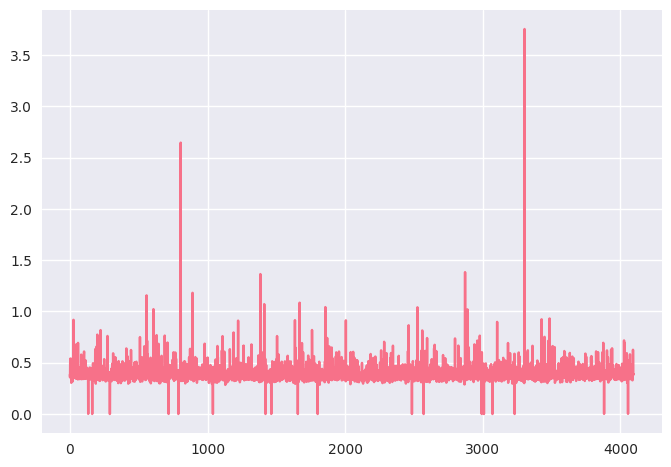

In [16]:
import matplotlib.pyplot as plt

plt.plot(stats['model.layers.0.mlp.gate_proj'])

We can see that most channels have relatively small maximum values, while a few channels exhibit large spikes (outliers).

In NVIDIA-compatible static quantization, we only have one scale per activations tensor.
This creates a trade-off:

- If we set the scale using the global maximum, the large outliers dominate, and the majority of channels (with small ranges) get quantized very coarsely, leading to significant information loss.

- If we instead use a percentile-based statistic to ignore extreme outliers, we improve quantization for the majority, but the channels with large values will saturate badly, also harming quality.

This imbalance in channel ranges is exactly what SmoothQuant addresses.
By redistributing the magnitude between weights and activations on a per-channel basis, SmoothQuant “flattens” these differences, enabling per-tensor quantization to work effectively without sacrificing quality on either small- or large-magnitude channels.

## 5. SmoothQuant Algorithm

As we already saw input activations of quantized modules may contain outliers that make quantization challenging. **SmoothQuant** is an algorithm designed to address this issue by redistributing quantization difficulty from activations to weights.

### How SmoothQuant Works:

1. **Problem**: Activations often contain outliers that are hard to quantize accurately
2. **Solution**: Apply a per-channel scaling factor to "smooth" activations and compensate in weights
3. **Formula**: For a linear layer Y = XW, we transform to Y = (X ⊙ s⁻¹)(W ⊙ s)
4. **Benefit**: Activations become easier to quantize while weights (which are typically easier to quantize) absorb the difficulty

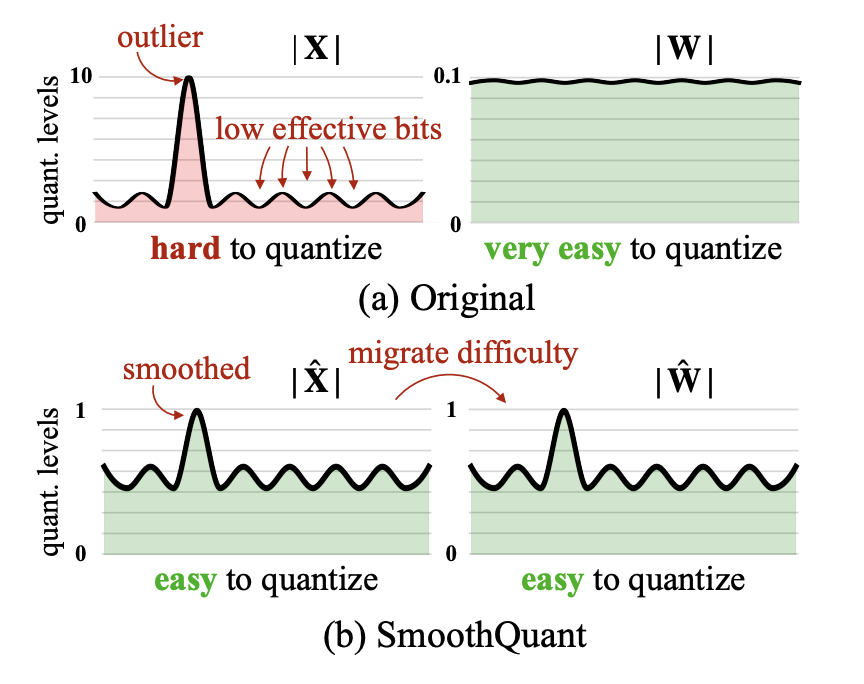

Let's apply SmoothQuant to our model:

In [6]:
print("Applying SmoothQuant algorithm...")

alpha = 0.8  # Smoothing factor
calibration_iterations = 100

# Apply SmoothQuant
model, handle = SmoothQuant.setup_model(
    model=model,
    alpha=alpha,
    **NVIDIA_INT_W8A8,
    calibration_iterations=calibration_iterations,
    inplace=True
)

print(f"SmoothQuant setup completed with α={alpha}")

Applying SmoothQuant algorithm...
SmoothQuant setup completed with α=0.8


Run model forward passes for calibration. It will:
1. Estimate equalization factors for each row in linear modules
2. Estimate quantization scales of smoothed model

In [7]:
# Step 1: Configure for equalization (smooth scaling collection)
SmoothQuant.configure_equalization(model)

with torch.no_grad():
    for i, batch in enumerate(
        tqdm(calib_loader, desc="Collecting smoothing scales", total=calibration_iterations)
    ):
        if i >= calibration_iterations:
            break
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        _ = model(input_ids, attention_mask=attention_mask)

# Step 2: Configure for quantization
SmoothQuant.configure_quantization(model)

with torch.no_grad():
    for i, batch in enumerate(
        tqdm(calib_loader, desc="Collecting quantization scales", total=calibration_iterations)
    ):
        if i > calibration_iterations:
            break
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        _ = model(input_ids, attention_mask=attention_mask)

model.eval()
print("SmoothQuant calibration completed!")

SmoothQuant calibration completed!


In [1]:
sq_results = evaluate_benchmarks(model, tokenizer, ['mmlu'], device, batch_size=4)
print(sq_results)

{'mmlu': 0.6031155040927458}


Remove registered quantizations

In [ ]:
handle.remove()

### 6 Dynamic quantization

To improve quality of quantized model we can use per token dynamic quantization scheme. 
It means that quantization scales are calculated on-fly 
during model inference for each token in the input activations tensor.

In [ ]:
model, handle, param_groups = PostTrainingQuantization.setup_model(
    model=model,
    **NVIDIA_INT_W8A8_PER_TOKEN_DYNAMIC,
    modules_types=(nn.Linear,),
    inplace=True
)
print("Quantization setup completed!")
print(f"Number of quantized modules: {len(handle._modules)}")

Dynamic quantization does not require calibration. So let's evaluate this model on MMLU.

In [11]:
dynamic_results = evaluate_benchmarks(model, tokenizer, ['mmlu'], device)
print(dynamic_results)

{'mmlu': 0.6652102170544192}


Cool! Quality of quantized model now is much better.